In [1]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score,roc_auc_score
import csv
import jieba.analyse
from keras.layers import LSTM, SpatialDropout1D, Dense, Conv1D, MaxPooling1D, Flatten
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# 数据预处理

In [2]:
# 读取数据
train_data = pd.read_csv(r"data\train.news.csv")
# 读取预训练的 word2vec 并构建词表
word2vec = open("data\sgns.sogounews.bigram-char", "r", encoding='UTF-8')
t = word2vec.readline().split()
n, dimension = int(t[0]), int(t[1])
wordAndVec = word2vec.readlines()
wordAndVec = [i.split() for i in wordAndVec]
vectorsMap = []
word2index = {}
index2word = {}
for i in range(n):
    vectorsMap.append(list(map(float, wordAndVec[i][len(wordAndVec[i]) - dimension:])))
    word2index[wordAndVec[i][0]] = i
    index2word[i] = wordAndVec[i][0]
word2vec.close()
print("finish reading")

finish reading


In [3]:
# jieba 分词与词向量构建
features_train = []
features_test = []
for title in train_data['Title']:
    word_feature = []
    for word in jieba.analyse.extract_tags(title,topK=130,withWeight=False,allowPOS=()):
        if word in word2index:
            word_feature.append(vectorsMap[word2index[word]])
    features_train.append(word_feature)
print("finish creating features_train")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LEGION\AppData\Local\Temp\jieba.cache
Loading model cost 0.603 seconds.
Prefix dict has been built successfully.


finish creating features_train


In [4]:
test_data = pd.read_csv(r"data\test.feature.csv")
for title in test_data['Title']:
    word_feature = []
    for word in jieba.analyse.extract_tags(title,topK=130,withWeight=False,allowPOS=()):
        if word in word2index:
            word_feature.append(vectorsMap[word2index[word]])
    features_test.append(word_feature)
print("finish creating features_test")

finish creating features_test


In [5]:
# 模型输入构建
max_len1 = max([len(i) for i in features_train])
max_len2 = max([len(i) for i in features_test])
max_len = max(max_len1, max_len2)
X_train = []
X_test = []
for sen in features_train:
    tl = sen
    tl += [[0] * dimension] * (max_len - len(tl))
    X_train.append(tl)
for sen in features_test:
    tl = sen
    tl += [[0] * dimension] * (max_len - len(tl))
    X_test.append(tl)
print("finish creating X_train X_test")
Y_train = train_data['label']
# 将 features_train 和 features_test 转换为模型输入的形式
X_train = pad_sequences(features_train, dtype='float32')
X_test = pad_sequences(features_test, dtype='float32')
# 处理标签
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(train_data['label'])
Y_train_onehot = to_categorical(Y_train_encoded)

finish creating X_train X_test


In [6]:
# 划分训练集和验证集 
X_train_split, X_validation, Y_train_split, Y_validation = train_test_split(X_train, Y_train_onehot,test_size=0.3,stratify=Y_train_onehot,random_state=42)
X_v_val,X_v_test,Y_v_val,Y_v_test, = train_test_split(X_validation, Y_validation,test_size=0.5,stratify=Y_validation,random_state=42)

# LSTM模型

Epoch 1/15



58/58 [==============================] - 6s 53ms/step - loss: 0.3614 - accuracy: 0.8598 - val_loss: 0.2580 - val_accuracy: 0.9125
Epoch 2/15
58/58 [==============================] - 2s 41ms/step - loss: 0.2206 - accuracy: 0.9235 - val_loss: 0.2051 - val_accuracy: 0.9251
Epoch 3/15
58/58 [==============================] - 2s 40ms/step - loss: 0.1874 - accuracy: 0.9364 - val_loss: 0.1950 - val_accuracy: 0.9332
Epoch 4/15
58/58 [==============================] - 2s 36ms/step - loss: 0.1472 - accuracy: 0.9511 - val_loss: 0.1992 - val_accuracy: 0.9358
Epoch 5/15
58/58 [==============================] - 2s 36ms/step - loss: 0.1189 - accuracy: 0.9598 - val_loss: 0.1759 - val_accuracy: 0.9458
Epoch 6/15
58/58 [==============================] - 2s 37ms/step - loss: 0.1032 - accuracy: 0.9684 - val_loss: 0.1724 - val_accuracy: 0.9477
Epoch 7/15
58/58 [==============================] - 2s 36ms/step - loss: 0.0834 - accuracy: 0.9740 - val_loss: 0.2041 - val_accuracy: 0.9471
Epoch 8/15
58/58 [======

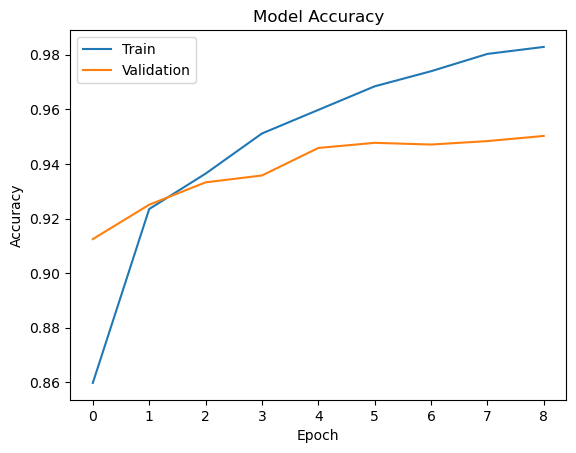

In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# 定义回调函数
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
tensorboard = TensorBoard(log_dir='./log')
# 模型训练
history = model.fit(X_train_split, Y_train_split, validation_data=(X_v_val, Y_v_val),
                    epochs=15, batch_size=128, callbacks=[early_stopping, tensorboard])
# 模型评估
loss, accuracy = model.evaluate(X_v_val, Y_v_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")
# 计算召回率、AUC和F1分数
y_validation_pred = model.predict(X_v_test)
y_validation_pred_binary = np.argmax(y_validation_pred, axis=1)
y_validation_true = np.argmax(Y_v_test, axis=1)
recall = recall_score(y_validation_true, y_validation_pred_binary)
auc_score = roc_auc_score(Y_v_test, y_validation_pred)
f1score = f1_score(y_validation_true, y_validation_pred_binary)
print(f"Recall: {recall}, AUC: {auc_score}, F1 Score: {f1score}")
# 可视化训练过程
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM-CNN(1层LSTM+2层卷积)

Epoch 1/10
58/58 [==============================] - 4s 35ms/step - loss: 0.3052 - accuracy: 0.8818 - val_loss: 0.2120 - val_accuracy: 0.9175
Epoch 2/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1891 - accuracy: 0.9290 - val_loss: 0.1921 - val_accuracy: 0.9263
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.1609 - accuracy: 0.9404 - val_loss: 0.1767 - val_accuracy: 0.9332
Epoch 4/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1255 - accuracy: 0.9524 - val_loss: 0.1722 - val_accuracy: 0.9389
Epoch 5/10
58/58 [==============================] - 2s 28ms/step - loss: 0.0960 - accuracy: 0.9642 - val_loss: 0.1846 - val_accuracy: 0.9433
Epoch 6/10
58/58 [==============================] - 2s 27ms/step - loss: 0.0694 - accuracy: 0.9752 - val_loss: 0.1951 - val_accuracy: 0.9465
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2078 - accuracy: 0.9490
Validation Loss: 0.207842156291008, Validation Accuracy:

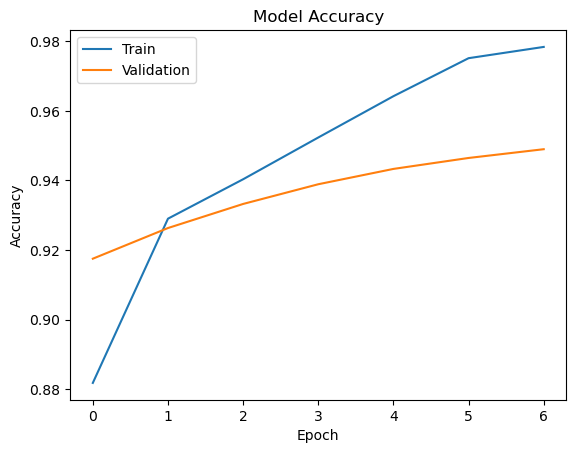

In [9]:
# 构建深度学习模型
model = Sequential()
# LSTM层
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(SpatialDropout1D(0.5))
# 添加第一层卷积层
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D())
# 添加第二层卷积层
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D())
# Flatten层用于将卷积层的输出展平
model.add(Flatten())
# 密集连接层
model.add(Dense(2, activation='softmax'))
# 编译模型

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 定义回调函数
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
tensorboard = TensorBoard(log_dir='./log')

# 模型训练
history = model.fit(X_train_split, Y_train_split, validation_data=(X_v_val, Y_v_val),
                    epochs=10, batch_size=128, callbacks=[early_stopping, tensorboard])

# 模型评估
loss, accuracy = model.evaluate(X_v_val, Y_v_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

y_validation_pred = model.predict(X_v_test)
y_validation_pred_binary = np.argmax(y_validation_pred, axis=1)
y_validation_true = np.argmax(Y_v_test, axis=1)
recall = recall_score(y_validation_true, y_validation_pred_binary)
auc_score = roc_auc_score(Y_v_test, y_validation_pred)
f1score = f1_score(y_validation_true, y_validation_pred_binary)
print(f"Recall: {recall}, AUC: {auc_score}, F1 Score: {f1score}")
# 可视化训练过程
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM-CNN(2层LSTM+2层卷积)

Epoch 1/20
58/58 [==============================] - 5s 37ms/step - loss: 0.3747 - accuracy: 0.8368 - val_loss: 0.2337 - val_accuracy: 0.9194
Epoch 2/20
58/58 [==============================] - 1s 25ms/step - loss: 0.2146 - accuracy: 0.9247 - val_loss: 0.2052 - val_accuracy: 0.9263
Epoch 3/20
58/58 [==============================] - 1s 25ms/step - loss: 0.1776 - accuracy: 0.9410 - val_loss: 0.2049 - val_accuracy: 0.9244
Epoch 4/20
58/58 [==============================] - 1s 25ms/step - loss: 0.1497 - accuracy: 0.9507 - val_loss: 0.1973 - val_accuracy: 0.9238
Epoch 5/20
58/58 [==============================] - 1s 25ms/step - loss: 0.1213 - accuracy: 0.9626 - val_loss: 0.2108 - val_accuracy: 0.9263
Epoch 6/20
58/58 [==============================] - 1s 26ms/step - loss: 0.1008 - accuracy: 0.9673 - val_loss: 0.1739 - val_accuracy: 0.9358
Epoch 7/20
58/58 [==============================] - 1s 26ms/step - loss: 0.0824 - accuracy: 0.9735 - val_loss: 0.1849 - val_accuracy: 0.9521
Epoch 8/20
58

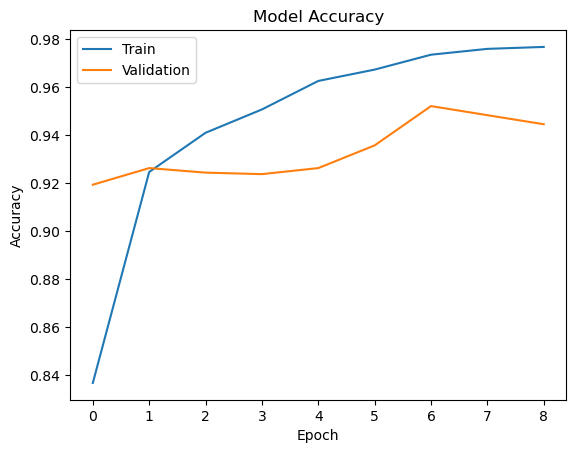

In [11]:
# 构建深度学习模型
model = Sequential()
# 添加第一层LSTM
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SpatialDropout1D(0.5))
# 添加第二层卷积层
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
# 添加第三层LSTM
model.add(LSTM(128, return_sequences=True))
model.add(SpatialDropout1D(0.5))
# 添加第四层卷积层
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
# Flatten层用于将卷积层的输出展平
model.add(Flatten())
# 密集连接层
model.add(Dense(2, activation='softmax'))
# 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 定义回调函数
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
tensorboard = TensorBoard(log_dir='./log')
# 模型训练
history = model.fit(X_train_split, Y_train_split, validation_data=(X_v_val, Y_v_val),
                    epochs=20, batch_size=128, callbacks=[early_stopping, tensorboard])
# 模型评估
loss, accuracy = model.evaluate(X_v_val, Y_v_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")
# 计算召回率、AUC和F1分数
y_validation_pred = model.predict(X_v_test)
y_validation_pred_binary = np.argmax(y_validation_pred, axis=1)
y_validation_true = np.argmax(Y_v_test, axis=1)
recall = recall_score(y_validation_true, y_validation_pred_binary)
auc_score = roc_auc_score(Y_v_test, y_validation_pred)
f1score = f1_score(y_validation_true, y_validation_pred_binary)
print(f"Recall: {recall}, AUC: {auc_score}, F1 Score: {f1score}")
# 可视化训练过程
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 模型预测

In [16]:
# 模型预测
predictions = model.predict(X_test)
# 保存预测结果
df_predictions = pd.DataFrame(predictions, columns=['0', '1'])
df_predictions.to_csv('data\predictions.csv', index=False)
np.savetxt('data\prediction.csv', predictions, delimiter=',', fmt='%f')
file = open('data\submit_example.csv', 'r')
submit = csv.reader(file)
prediction1 = []
prediction2 = []
for pre in predictions:
    prediction1.append(pre[0])
    prediction2.append(pre[1])
prediction = []
for i, j in zip(prediction1, prediction2):
    prediction.append(int(float(j)>0.1))
id = []
for k in submit:
    if k[0]=='id':
        continue
    id.append(k[0])
series1 = pd.Series(prediction)
series2 = pd.Series(id)
df = pd.DataFrame({'id': series2, 'label': series1})
df.to_csv("data\submit.csv", index=False)

317/317 [==============================] - 2s 5ms/step
1 2082 0 8059
